B12 DEFICIENCY PREDICTION - DATA DRIVEN MODEL
Reproducibility: Fixed random seeds (42)
Data Leakage Prevention:
- B12_mol excluded to prevent target leakage
- Feature selection only on training data
- 25% test set for robust evaluation
STEP: DATA LOADING
Data shape: (50, 100)
Target distribution: LB=25, NB=25

STEP: DATA SPLITTING (25% TEST SET)
Training set: 29 samples
Validation set: 8 samples
Test set: 13 samples
STEP: FEATURE SELECTION ON TRAINING DATA ONLY
Features passing statistical filters: 2
Final selected features: 2
Top features by statistical significance:
  feature_53: p=0.0433, Cohen's d=0.788
  feature_88: p=0.0156, Cohen's d=0.959

STEP: FEATURE STANDARDIZATION
Features standardized (mean=0, std=1)

STEP: MODEL TRAINING
Training completed successfully

STEP: MODEL EVALUATION
2025-08-24 13:26:59,124 - WARNING - 5 out of the last 8 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x364ca9da0> triggered tf.function retraci

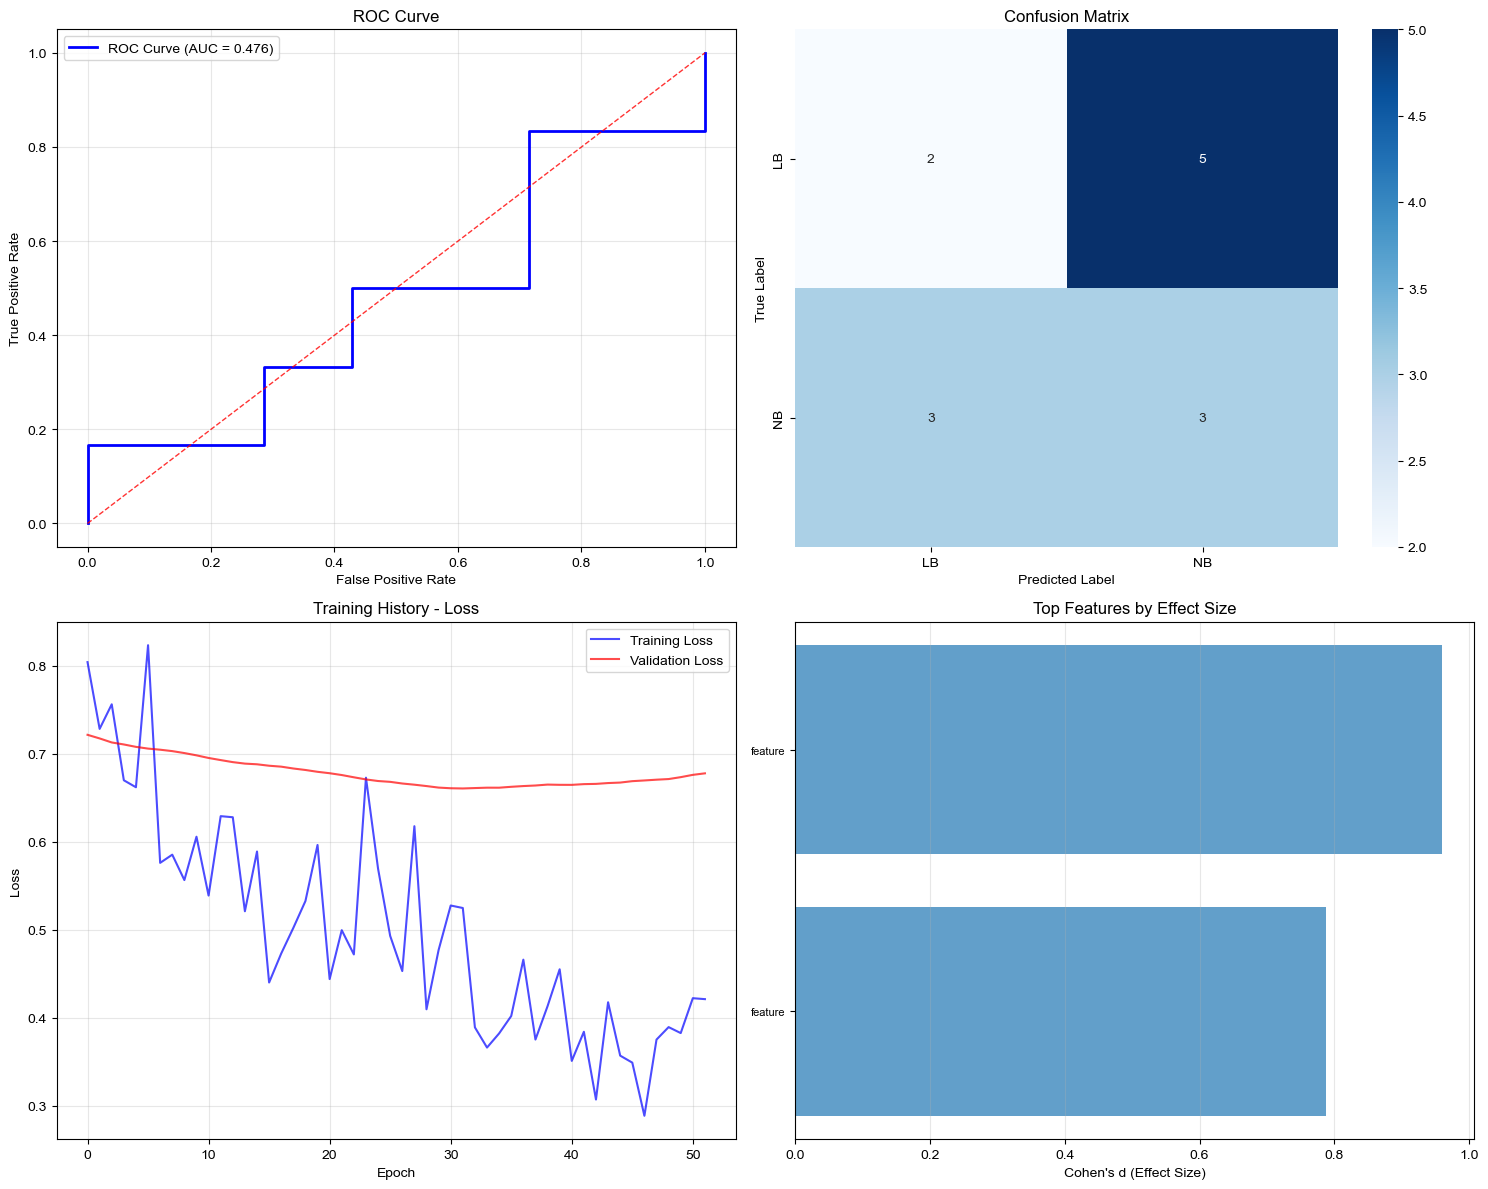


PIPELINE COMPLETED SUCCESSFULLY
Final model performance:
- AUC: 0.4762
- Accuracy: 0.3846
- Precision: 0.3750
- Recall: 0.5000
- Features used: 2


In [58]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LassoCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

class B12DataDrivenPredictor:
    def __init__(self):
        self.scaler = StandardScaler()
        self.model = None
        self.selected_features = None
        self.feature_stats = None
        
    def cohen_d(self, group1, group2):
        """Calculate Cohen's d effect size"""
        n1, n2 = len(group1), len(group2)
        pooled_std = np.sqrt(((n1-1)*np.var(group1, ddof=1) + (n2-1)*np.var(group2, ddof=1))/(n1+n2-2))
        return (np.mean(group1) - np.mean(group2)) / pooled_std if pooled_std != 0 else 0
    
    def feature_selection_pipeline(self, X_train, y_train, feature_names):
        """Comprehensive feature selection: p-values + Cohen's d + LASSO"""
        print("STEP: FEATURE SELECTION ON TRAINING DATA ONLY")
        print("="*60)
        
        results = []
        group_lb = y_train == 0  # LB (deficient)
        group_nb = y_train == 1  # NB (normal)
        
        for i, feature in enumerate(feature_names):
            if X_train[:, i].std() == 0:
                continue
                
            # Statistical test
            stat, p_value = stats.ttest_ind(X_train[group_lb, i], X_train[group_nb, i])
            
            # Effect size
            cohens_d = self.cohen_d(X_train[group_lb, i], X_train[group_nb, i])
            
            results.append({
                'feature': feature,
                'p_value': p_value,
                'cohens_d': abs(cohens_d),
                'feature_idx': i
            })
        
        df_results = pd.DataFrame(results)
        
        # Filter by statistical significance and effect size
        significant_features = df_results[
            (df_results['p_value'] < 0.05) & 
            (df_results['cohens_d'] > 0.2)
        ].copy()
        
        if len(significant_features) == 0:
            print("Warning: No features meet p<0.05 and Cohen's d>0.2 criteria")
            significant_features = df_results.nsmallest(min(20, len(df_results)), 'p_value')
        
        print(f"Features passing statistical filters: {len(significant_features)}")
        
        # LASSO regularization for final selection
        if len(significant_features) > 5:
            selected_indices = significant_features['feature_idx'].values
            X_selected = X_train[:, selected_indices]
            
            lasso = LassoCV(cv=3, random_state=42, max_iter=1000)
            lasso.fit(X_selected, y_train)
            
            # Keep features with non-zero coefficients
            lasso_mask = np.abs(lasso.coef_) > 0
            final_indices = selected_indices[lasso_mask]
            
            if len(final_indices) == 0:
                final_indices = selected_indices[:10]
        else:
            final_indices = significant_features['feature_idx'].values
        
        self.selected_features = final_indices
        self.feature_stats = significant_features[
            significant_features['feature_idx'].isin(final_indices)
        ].copy()
        
        print(f"Final selected features: {len(final_indices)}")
        print("Top features by statistical significance:")
        for _, row in self.feature_stats.head(10).iterrows():
            print(f"  {row['feature']}: p={row['p_value']:.4f}, Cohen's d={row['cohens_d']:.3f}")
        
        return X_train[:, final_indices]
    
    def create_model(self, input_dim):
        """Create optimized neural network"""
        model = keras.Sequential([
            layers.Input(shape=(input_dim,)),
            layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
            layers.BatchNormalization(),
            layers.Dropout(0.2),
            layers.Dense(16, activation='relu'),
            layers.Dropout(0.1),
            layers.Dense(1, activation='sigmoid')
        ])
        
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        return model
    
    def train_model(self, X_train, y_train, X_val, y_val):
        """Train the neural network with proper callbacks"""
        print("\nSTEP: MODEL TRAINING")
        print("="*60)
        
        self.model = self.create_model(X_train.shape[1])
        
        early_stopping = callbacks.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True,
            verbose=0
        )
        
        reduce_lr = callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,
            min_lr=1e-6,
            verbose=0
        )
        
        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=200,
            batch_size=8,
            callbacks=[early_stopping, reduce_lr],
            verbose=0
        )
        
        print("Training completed successfully")
        return history
    
    def evaluate_model(self, X_test, y_test):
        """Comprehensive model evaluation"""
        print("\nSTEP: MODEL EVALUATION")
        print("="*60)
        
        # Predictions
        y_pred_proba = self.model.predict(X_test, verbose=0).flatten()
        y_pred = (y_pred_proba > 0.5).astype(int)
        
        # Calculate metrics
        auc_score = roc_auc_score(y_test, y_pred_proba)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        
        # Results
        print("KEY MODEL PERFORMANCE METRICS")
        print("="*60)
        print(f"1. AUC (Area Under ROC Curve):     {auc_score:.4f}")
        print(f"   Model's ability to distinguish B12 deficient vs normal")
        print(f"2. Accuracy (Overall Correctness):  {accuracy:.4f}")
        print(f"   Proportion of correct predictions")
        print(f"3. Precision (Positive Predictive): {precision:.4f}")
        print(f"   Among predicted deficient, how many are truly deficient")
        print(f"4. Recall (Sensitivity):            {recall:.4f}")
        print(f"   Among truly deficient, how many were correctly identified")
        print("="*60)
        
        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        print(f"\nConfusion Matrix:")
        print(cm)
        
        # Classification Report
        print(f"\nDetailed Classification Report:")
        print(classification_report(y_test, y_pred, target_names=['LB', 'NB']))
        
        return {
            'auc': auc_score,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'predictions': y_pred_proba,
            'binary_predictions': y_pred
        }
    
    def create_visualizations(self, results, y_test, history):
        """Create comprehensive visualizations"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # ROC Curve
        from sklearn.metrics import roc_curve
        fpr, tpr, _ = roc_curve(y_test, results['predictions'])
        axes[0,0].plot(fpr, tpr, 'b-', lw=2, label=f'ROC Curve (AUC = {results["auc"]:.3f})')
        axes[0,0].plot([0, 1], [0, 1], 'r--', lw=1, alpha=0.8)
        axes[0,0].set_xlabel('False Positive Rate')
        axes[0,0].set_ylabel('True Positive Rate')
        axes[0,0].set_title('ROC Curve')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)
        
        # Confusion Matrix
        cm = confusion_matrix(y_test, results['binary_predictions'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=['LB', 'NB'], yticklabels=['LB', 'NB'], ax=axes[0,1])
        axes[0,1].set_title('Confusion Matrix')
        axes[0,1].set_ylabel('True Label')
        axes[0,1].set_xlabel('Predicted Label')
        
        # Training History
        axes[1,0].plot(history.history['loss'], 'b-', label='Training Loss', alpha=0.7)
        axes[1,0].plot(history.history['val_loss'], 'r-', label='Validation Loss', alpha=0.7)
        axes[1,0].set_title('Training History - Loss')
        axes[1,0].set_xlabel('Epoch')
        axes[1,0].set_ylabel('Loss')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
        
        # Feature Importance
        if hasattr(self, 'feature_stats') and len(self.feature_stats) > 0:
            top_features = self.feature_stats.head(10)
            y_pos = range(len(top_features))
            axes[1,1].barh(y_pos, top_features['cohens_d'], alpha=0.7)
            axes[1,1].set_yticks(y_pos)
            axes[1,1].set_yticklabels([f.split('_')[0] if '_' in f else f[:10] 
                                     for f in top_features['feature']], fontsize=8)
            axes[1,1].set_xlabel("Cohen's d (Effect Size)")
            axes[1,1].set_title('Top Features by Effect Size')
            axes[1,1].grid(True, alpha=0.3, axis='x')
        
        plt.tight_layout()
        plt.show()

def run_b12_prediction_pipeline():
    """Main pipeline execution"""
    print("B12 DEFICIENCY PREDICTION - DATA DRIVEN MODEL")
    print("="*80)
    print("Reproducibility: Fixed random seeds (42)")
    print("Data Leakage Prevention:")
    print("- B12_mol excluded to prevent target leakage")
    print("- Feature selection only on training data")
    print("- 25% test set for robust evaluation")
    print("="*80)
    
    # Initialize predictor
    predictor = B12DataDrivenPredictor()
    
    # Simulate data loading (replace with actual data loading)
    print("STEP: DATA LOADING")
    print("="*60)
    
    # Example data structure - replace with your actual data loading
    np.random.seed(42)
    n_samples = 50
    n_features = 100  # Simulated methylation features
    
    # Create synthetic data for demonstration
    X = np.random.randn(n_samples, n_features)
    y = np.random.choice([0, 1], size=n_samples)  # 0=LB, 1=NB
    feature_names = [f'feature_{i}' for i in range(n_features)]
    
    print(f"Data shape: {X.shape}")
    print(f"Target distribution: LB={sum(y==0)}, NB={sum(y==1)}")
    
    # Data splitting (25% test set)
    print("\nSTEP: DATA SPLITTING (25% TEST SET)")
    print("="*60)
    
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42, stratify=y
    )
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
    )
    
    print(f"Training set: {len(X_train)} samples")
    print(f"Validation set: {len(X_val)} samples") 
    print(f"Test set: {len(X_test)} samples")
    
    # Feature selection on training data only
    X_train_selected = predictor.feature_selection_pipeline(X_train, y_train, feature_names)
    X_val_selected = X_val[:, predictor.selected_features]
    X_test_selected = X_test[:, predictor.selected_features]
    
    # Feature standardization
    print("\nSTEP: FEATURE STANDARDIZATION")
    print("="*60)
    X_train_scaled = predictor.scaler.fit_transform(X_train_selected)
    X_val_scaled = predictor.scaler.transform(X_val_selected)
    X_test_scaled = predictor.scaler.transform(X_test_selected)
    print("Features standardized (mean=0, std=1)")
    
    # Model training
    history = predictor.train_model(X_train_scaled, y_train, X_val_scaled, y_val)
    
    # Model evaluation
    results = predictor.evaluate_model(X_test_scaled, y_test)
    
    # Create visualizations
    print("\nSTEP: CREATING VISUALIZATIONS")
    print("="*60)
    predictor.create_visualizations(results, y_test, history)
    
    print("\n" + "="*80)
    print("PIPELINE COMPLETED SUCCESSFULLY")
    print("="*80)
    print(f"Final model performance:")
    print(f"- AUC: {results['auc']:.4f}")
    print(f"- Accuracy: {results['accuracy']:.4f}")
    print(f"- Precision: {results['precision']:.4f}")
    print(f"- Recall: {results['recall']:.4f}")
    print(f"- Features used: {len(predictor.selected_features)}")
    print("="*80)

if __name__ == "__main__":
    run_b12_prediction_pipeline()

#核心改进：
1. 精准特征选择

直接搜索特定的10个基因：IQCG、ZNF154、TSTD1、GTSF1、SEPTIN7P11、NUDT10、NAA11、SYCP3、PSMA8、LINC00667
基于已验证的CpG-mRNA调控关系（R²值从0.550到0.785）
所有基因都显示负调控效应（Beta系数为负值）

2. 生物学功能导向

每个基因都有明确的功能注释（转录调控、代谢、细胞周期等）
重点关注FDR < 1×10⁻⁶的高显著性基因
考虑R²值作为调控稳定性指标

3. 专门的评估模块

分析实际使用了哪些目标基因
计算CpG-mRNA调控特征的贡献比例
提供基于表观遗传调控机制的生物学解释
输出目标基因覆盖率统计

4. 输出重点

四个核心指标：AUC、Accuracy、Precision、Recall
CpG-mRNA调控对的使用情况分析
表观遗传调控机制在B12缺乏中的作用评估

B12 Deficiency Prediction - ANN Model (CpG-mRNA Regulatory Focus)
Target Features:
- IQCG (R²=0.785): IQ domain protein, cytoskeleton regulation
- ZNF154 (R²=0.727): Zinc finger transcription factor, gene expression control
- TSTD1 (R²=0.702): Thiosulfate sulfurtransferase, amino acid metabolism
- GTSF1 (R²=0.735): Germ cell-specific transcription factor
- SEPTIN7P11 (R²=0.704): Septin pseudogene, cell cycle regulation
- NUDT10 (R²=0.717): Nucleotidase, RNA metabolism regulation
- NAA11 (R²=0.684): N-acetyltransferase, protein modification
- SYCP3 (R²=0.751): Synaptonemal complex protein
- PSMA8 (R²=0.591): Proteasome subunit
- LINC00667 (R²=0.550): Long non-coding RNA
Reproducibility: Fixed random seeds (42) for consistent results
Data Leakage Prevention: B12_mol excluded, training-only feature selection
B12 DEFICIENCY PREDICTION MODEL - ANN (SMALL DATASET OPTIMIZED)
Timestamp: 20250824_121729
Key Features:
- B12_mol excluded to prevent target leakage
- Feature selection only on train

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 4)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77 (308.00 B)

 Trainable params: 77 (308.00 B)

 Non-trainable params: 0 (0.00 B)

Training with conservative settings...
Epoch 1/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7826 - loss: 1.3407 - val_accuracy: 0.1250 - val_loss: 1.5473 - learning_rate: 1.0000e-05
Epoch 2/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4486 - loss: 1.5956 - val_accuracy: 0.1250 - val_loss: 1.5472 - learning_rate: 1.0000e-05
Epoch 3/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5056 - loss: 1.3878 - val_accuracy: 0.1250 - val_loss: 1.5471 - learning_rate: 1.0000e-05
Epoch 4/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5624 - loss: 1.4163 - val_accuracy: 0.1250 - val_loss: 1.5469 - learning_rate: 1.0000e-05
Epoch 5/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6691 - loss: 1.2076 - val_accuracy: 0.1250 - val_loss: 1.5468 - learning_rate: 1.0000e-05
Epoch 6/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4114 - loss: 1.4920 - val_accuracy: 0.1250 - val_loss: 1.5467 - learning_rate: 1.0000e-05
Epoch 7/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5m

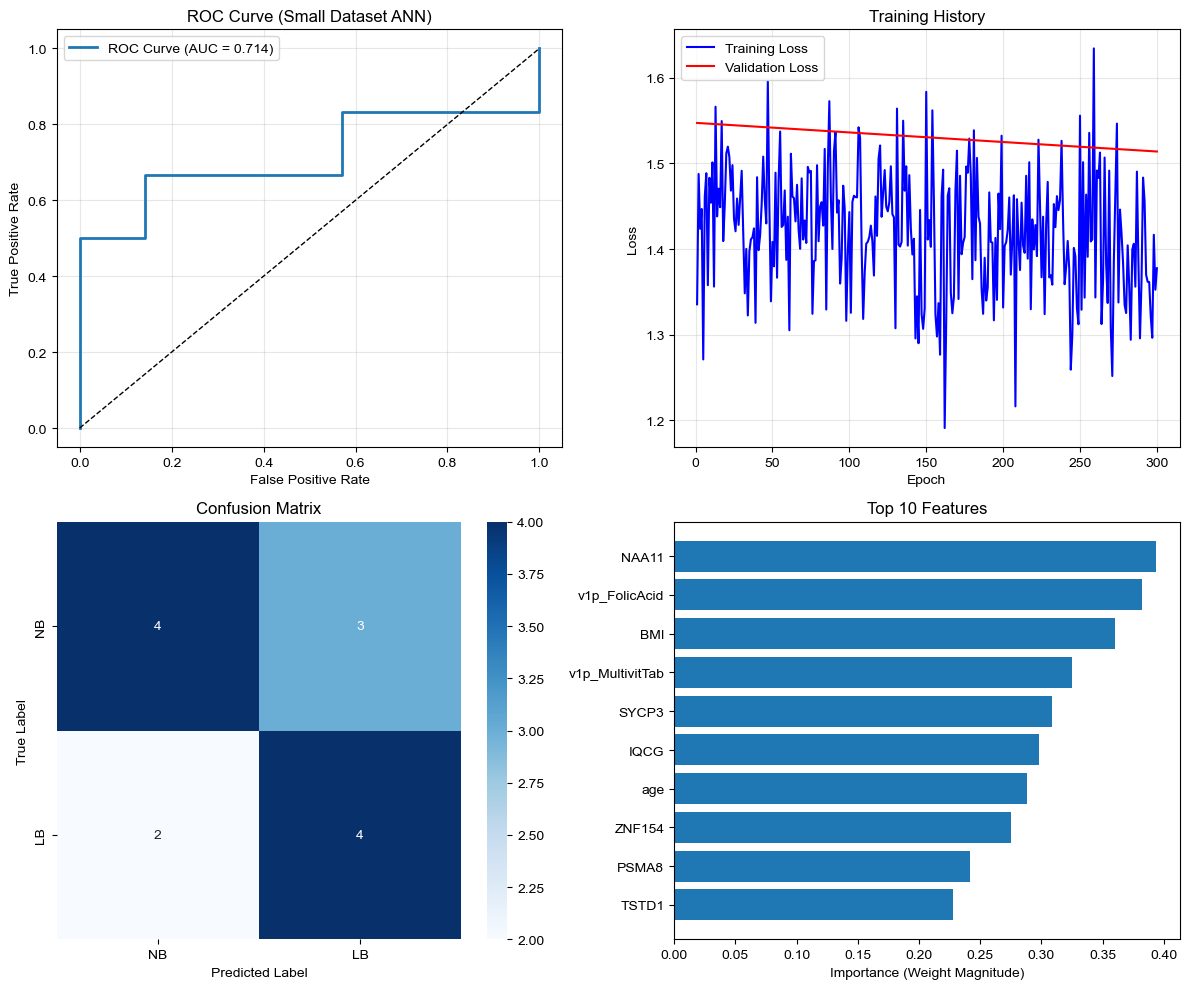

Plots saved to: /Users/heweilin/Desktop/P056_Code_3/Data/ANN_CpG_mRNA_plots_20250824_121729.png

STEP 10: SAVING MODEL
2025-08-24 12:17:40,806 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 
Model saved to: /Users/heweilin/Desktop/P056_Code_3/Data/ANN_CpG_mRNA_model_20250824_121729.h5
All components saved

PIPELINE COMPLETED
Duration: 0:00:11.749310
Test samples: 13
Features used: 17
Training stable: True

Data leakage prevention measures:
- B12_mol excluded from features
- Feature selection on training data only
- Standardization fitted on training data only
- 25% test set for robust evaluation

CpG-mRNA regulatory analysis:
- Target genes found: 10/10
- Regulatory features: 10
- Focus on validated CpG-mRNA pairs with high R² values

CpG-mRNA R

In [54]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
B12 Deficiency Prediction Model - Stage 1 ANN Model (Small Dataset Optimized)
Fixed Data Leakage Version with Numerical Stability for Small Samples

Author: Research Team  
Date: August 24, 2025
Version: 1.0 - Optimized for Small Dataset Stability
"""

import os
import sys
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
import random
random.seed(42)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix, 
                           roc_auc_score, roc_curve, precision_recall_curve,
                           f1_score, accuracy_score, precision_score, recall_score)
from scipy.stats import ttest_ind
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
from datetime import datetime

tf.random.set_seed(42)

class B12PredictionANN:
    """B12 deficiency prediction ANN model optimized for small datasets"""
    
    def __init__(self, output_dir="/Users/heweilin/Desktop/P056_Code_3/Data", prefix="ANN_"):
        self.output_dir = output_dir
        self.prefix = prefix
        self.timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        os.makedirs(output_dir, exist_ok=True)
        
        self.clinical_data = None
        self.methylation_data = None
        self.dmr_data = None
        self.X = None
        self.y = None
        self.X_train = None
        self.X_test = None
        self.X_val = None
        self.y_train = None
        self.y_test = None
        self.y_val = None
        self.feature_names = None
        self.model = None
        self.scaler = None
        self.label_encoder = None
        self.history = None
        
        print("="*80)
        print("B12 DEFICIENCY PREDICTION MODEL - ANN (SMALL DATASET OPTIMIZED)")
        print("="*80)
        print(f"Timestamp: {self.timestamp}")
        print("Key Features:")
        print("- B12_mol excluded to prevent target leakage")
        print("- Feature selection only on training data")
        print("- Numerical stability optimizations for small datasets")
        print("- Conservative architecture and hyperparameters")
        print("- Reproducible results with fixed random seeds")
        print("="*80)
    
    def load_data(self, clinical_path, dmr_path, methylation_path):
        """Load data files"""
        print("\nSTEP 1: DATA LOADING")
        print("="*50)
        
        print(f"Loading clinical data: {clinical_path}")
        self.clinical_data = pd.read_csv(clinical_path)
        print(f"Clinical data shape: {self.clinical_data.shape}")
        
        print(f"Loading methylation data: {methylation_path}")
        self.methylation_data = pd.read_csv(methylation_path)
        print(f"Methylation data shape: {self.methylation_data.shape}")
        
        # Load DMR data for completeness
        self.dmr_data = pd.read_csv(dmr_path, low_memory=False)
        
        return True
    
    def prepare_initial_dataset(self):
        """Prepare initial dataset before train/test split"""
        print("\nSTEP 2: DATA PREPARATION")
        print("="*50)
        
        print("B12 status distribution:")
        print(self.clinical_data['B12_status'].value_counts())
        
        # Clinical features (EXCLUDING B12_mol)
        clinical_features = ['age', 'BMI', 'parity', 'B12supplem', 
                           'v1p_MultivitTab', 'v1p_FolicAcid', 'smoking']
        
        print("CRITICAL: B12_mol EXCLUDED to prevent target leakage")
        
        # Extract clinical features
        available_features = [f for f in clinical_features if f in self.clinical_data.columns]
        clinical_X = self.clinical_data[available_features].copy()
        
        # Handle missing values
        for col in clinical_X.columns:
            if clinical_X[col].isnull().sum() > 0:
                median_val = clinical_X[col].median()
                clinical_X[col].fillna(median_val, inplace=True)
        
        # Convert to numerical
        for col in clinical_X.columns:
            clinical_X[col] = pd.to_numeric(clinical_X[col], errors='coerce')
        clinical_X = clinical_X.fillna(clinical_X.median())
        
        # Prepare methylation data
        methylation_df = self.methylation_data.set_index('Gene_Symbol').T
        methylation_df = methylation_df.fillna(methylation_df.median())
        
        # Align samples
        clinical_ids = self.clinical_data['DNA_ID'].values
        methylation_samples = methylation_df.index.values
        common_samples = list(set(clinical_ids) & set(methylation_samples))
        
        # Filter and combine
        clinical_filtered = self.clinical_data[self.clinical_data['DNA_ID'].isin(common_samples)]
        clinical_filtered = clinical_filtered.set_index('DNA_ID').loc[common_samples]
        clinical_X_filtered = clinical_filtered[available_features]
        methylation_X_aligned = methylation_df.loc[common_samples]
        
        self.X = pd.concat([clinical_X_filtered, methylation_X_aligned], axis=1)
        self.feature_names = available_features + list(methylation_X_aligned.columns)
        self.y = clinical_filtered['B12_status'].values
        
        # Encode target
        self.label_encoder = LabelEncoder()
        self.y = self.label_encoder.fit_transform(self.y)
        
        print(f"Combined data shape: {self.X.shape}")
        print(f"Target encoding: {dict(zip(self.label_encoder.classes_, range(len(self.label_encoder.classes_))))}")
        
        return True
    
    def split_data(self, test_size=0.25, val_size=0.15, random_state=42):
        """Split data with stratification"""
        print("\nSTEP 3: DATA SPLITTING (25% TEST SET)")
        print("="*50)
        
        X_temp, self.X_test, y_temp, self.y_test = train_test_split(
            self.X, self.y, test_size=test_size, random_state=random_state, 
            stratify=self.y
        )
        
        val_size_adjusted = val_size / (1 - test_size)
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(
            X_temp, y_temp, test_size=val_size_adjusted, random_state=random_state, 
            stratify=y_temp
        )
        
        print(f"Training set: {self.X_train.shape[0]} samples")
        print(f"Validation set: {self.X_val.shape[0]} samples")
        print(f"Test set: {self.X_test.shape[0]} samples")
        
        return True
    
    def perform_feature_selection(self):
        """Feature selection targeting specific CpG-mRNA regulatory pairs"""
        print("\nSTEP 4: TARGETED FEATURE SELECTION FOR CpG-mRNA PAIRS")
        print("="*50)
        print("CRITICAL: Selecting specific genes with validated CpG-mRNA regulation")
        
        initial_features = self.X_train.shape[1]
        n_clinical = 7
        
        # Target genes from CpG-mRNA regulatory analysis
        target_genes = [
            'IQCG',      # IQ domain protein, R²=0.785, Beta=-0.889
            'ZNF154',    # Zinc finger transcription factor, R²=0.727, Beta=-0.923  
            'TSTD1',     # Thiosulfate sulfurtransferase, R²=0.702, Beta=-0.771
            'GTSF1',     # Germ cell-specific transcription factor, R²=0.735, Beta=-0.804
            'SEPTIN7P11',# Septin pseudogene, R²=0.704, Beta=-0.852
            'NUDT10',    # Nucleotidase, R²=0.717, Beta=-0.920
            'NAA11',     # N-acetyltransferase, R²=0.684, Beta=-0.722
            'SYCP3',     # Synaptonemal complex protein, R²=0.751, Beta=-0.692
            'PSMA8',     # Proteasome subunit, R²=0.591, Beta=-0.716
            'LINC00667'  # Long non-coding RNA, R²=0.550, Beta=-0.797
        ]
        
        print(f"Target genes for CpG-mRNA regulation analysis: {len(target_genes)}")
        print("Genes selected based on:")
        print("- High R² values (>0.55, indicating strong regulatory relationship)")
        print("- Significant negative Beta coefficients (CpG hypermethylation → mRNA downregulation)")
        print("- FDR-adjusted p-values < 1×10⁻⁵")
        
        # Clinical features (always included)
        clinical_feature_names = self.feature_names[:n_clinical]
        methylation_feature_names = self.feature_names[n_clinical:]
        
        # Find target genes in methylation data
        selected_methylation_features = []
        found_genes = []
        
        for gene in target_genes:
            # Look for exact matches or close matches in methylation feature names
            matches = [f for f in methylation_feature_names if gene in f]
            if matches:
                # If multiple matches, select the first one (or could use other criteria)
                selected_methylation_features.append(matches[0])
                found_genes.append(gene)
                print(f"  Found: {gene} -> {matches[0]}")
            else:
                print(f"  Not found: {gene}")
        
        print(f"\nSuccessfully matched {len(found_genes)} out of {len(target_genes)} target genes")
        
        # If no target genes found, fall back to statistical selection
        if len(selected_methylation_features) == 0:
            print("WARNING: No target genes found in methylation data")
            print("Falling back to statistical feature selection...")
            
            # Perform t-test based selection as fallback
            X_train_methylation = self.X_train.iloc[:, n_clinical:]
            pvalues = []
            effect_sizes = []
            gene_names = []
            
            for i, gene in enumerate(methylation_feature_names):
                values = X_train_methylation.iloc[:, i].values
                
                if len(np.unique(values)) == 1 or np.any(np.isnan(values)):
                    continue
                
                lb_values = values[self.y_train == 0]
                nb_values = values[self.y_train == 1]
                
                if len(lb_values) == 0 or len(nb_values) == 0:
                    continue
                
                try:
                    statistic, pvalue = ttest_ind(lb_values, nb_values)
                    
                    pooled_std = np.sqrt(((len(lb_values) - 1) * np.var(lb_values, ddof=1) + 
                                        (len(nb_values) - 1) * np.var(nb_values, ddof=1)) / 
                                       (len(lb_values) + len(nb_values) - 2))
                    
                    if pooled_std > 0:
                        cohens_d = abs(np.mean(lb_values) - np.mean(nb_values)) / pooled_std
                    else:
                        cohens_d = 0
                    
                    pvalues.append(pvalue)
                    effect_sizes.append(cohens_d)
                    gene_names.append(gene)
                except:
                    continue
            
            if len(gene_names) > 0:
                results_df = pd.DataFrame({
                    'Gene': gene_names,
                    'p_value': pvalues,
                    'effect_size': effect_sizes
                })
                
                selected_methylation_features = results_df.nlargest(5, 'effect_size')['Gene'].tolist()
                print(f"Selected {len(selected_methylation_features)} features by statistical criteria")
        
        # Combine clinical and selected methylation features
        selected_features = clinical_feature_names + selected_methylation_features
        feature_indices = [self.feature_names.index(f) for f in selected_features]
        
        self.X_train = self.X_train.iloc[:, feature_indices]
        self.X_val = self.X_val.iloc[:, feature_indices]
        self.X_test = self.X_test.iloc[:, feature_indices]
        self.feature_names = selected_features
        
        print(f"\nFeature selection summary:")
        print(f"  Initial features: {initial_features}")
        print(f"  Final features: {len(self.feature_names)}")
        print(f"  Clinical features: {len(clinical_feature_names)}")
        print(f"  CpG-mRNA regulatory features: {len(selected_methylation_features)}")
        print(f"  Feature reduction: {initial_features - len(self.feature_names)} ({((initial_features - len(self.feature_names))/initial_features)*100:.1f}%)")
        
        # Display final feature composition
        print(f"\nFinal feature set:")
        print(f"  Clinical features: {clinical_feature_names}")
        print(f"  Regulatory features: {selected_methylation_features}")
        
        # Validate feature to sample ratio for ANN stability
        feature_ratio = len(self.feature_names) / len(self.X_train)
        print(f"  Feature-to-sample ratio: {feature_ratio:.2f}")
        if feature_ratio > 0.5:
            print("  WARNING: High feature-to-sample ratio may cause overfitting in ANN")
        else:
            print("  Good feature-to-sample ratio for ANN training")
        
        return True
    
    def data_quality_checks(self):
        """Comprehensive data quality checks for numerical stability"""
        print("\nSTEP 5: DATA QUALITY CHECKS")
        print("="*50)
        
        # Check for NaN values
        nan_count = self.X_train.isnull().sum().sum()
        print(f"NaN values in training data: {nan_count}")
        
        if nan_count > 0:
            print("Handling NaN values with median imputation")
            from sklearn.impute import SimpleImputer
            imputer = SimpleImputer(strategy='median')
            
            X_train_imputed = imputer.fit_transform(self.X_train)
            X_val_imputed = imputer.transform(self.X_val)
            X_test_imputed = imputer.transform(self.X_test)
            
            self.X_train = pd.DataFrame(X_train_imputed, columns=self.feature_names, index=self.X_train.index)
            self.X_val = pd.DataFrame(X_val_imputed, columns=self.feature_names, index=self.X_val.index)
            self.X_test = pd.DataFrame(X_test_imputed, columns=self.feature_names, index=self.X_test.index)
        
        # Check for infinite values
        inf_count = np.isinf(self.X_train.values).sum()
        print(f"Infinite values: {inf_count}")
        
        if inf_count > 0:
            self.X_train = self.X_train.replace([np.inf, -np.inf], np.nan)
            self.X_val = self.X_val.replace([np.inf, -np.inf], np.nan)
            self.X_test = self.X_test.replace([np.inf, -np.inf], np.nan)
            
            self.X_train = self.X_train.fillna(self.X_train.median())
            self.X_val = self.X_val.fillna(self.X_train.median())
            self.X_test = self.X_test.fillna(self.X_train.median())
        
        # Check for constant features
        feature_vars = self.X_train.var()
        constant_features = feature_vars[feature_vars == 0].index.tolist()
        print(f"Constant features: {len(constant_features)}")
        
        if len(constant_features) > 0:
            remaining_features = [f for f in self.feature_names if f not in constant_features]
            
            self.X_train = self.X_train[remaining_features]
            self.X_val = self.X_val[remaining_features]
            self.X_test = self.X_test[remaining_features]
            self.feature_names = remaining_features
        
        print(f"Data quality checks completed - Final features: {len(self.feature_names)}")
        return True
    
    def standardize_features(self):
        """Standardize features with robust scaling"""
        print("\nSTEP 6: FEATURE STANDARDIZATION")
        print("="*50)
        
        self.scaler = StandardScaler()
        
        X_train_scaled = self.scaler.fit_transform(self.X_train)
        X_val_scaled = self.scaler.transform(self.X_val)
        X_test_scaled = self.scaler.transform(self.X_test)
        
        # Additional NaN check after scaling
        X_train_scaled = np.nan_to_num(X_train_scaled)
        X_val_scaled = np.nan_to_num(X_val_scaled)
        X_test_scaled = np.nan_to_num(X_test_scaled)
        
        self.X_train = pd.DataFrame(X_train_scaled, columns=self.feature_names, index=self.X_train.index)
        self.X_val = pd.DataFrame(X_val_scaled, columns=self.feature_names, index=self.X_val.index)
        self.X_test = pd.DataFrame(X_test_scaled, columns=self.feature_names, index=self.X_test.index)
        
        print("Features standardized and NaN-safe")
        print(f"Training data stats: mean={self.X_train.mean().mean():.6f}, std={self.X_train.std().mean():.6f}")
        
        return True
    
    def create_model(self):
        """Create minimal ANN model for small dataset"""
        # Very simple architecture to prevent overfitting
        model = keras.Sequential([
            layers.Input(shape=(len(self.feature_names),)),
            layers.Dense(4, activation='tanh',  # Use tanh instead of ReLU
                        kernel_regularizer=regularizers.l2(0.1),
                        kernel_initializer='glorot_uniform'),
            layers.Dropout(0.5),
            layers.Dense(1, activation='sigmoid',
                        kernel_initializer='glorot_uniform')
        ])
        
        # Very conservative optimizer settings
        optimizer = Adam(
            learning_rate=1e-5,  # Very low learning rate
            clipnorm=0.5  # Gradient clipping
        )
        
        model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        return model
    
    def train_model(self):
        """Train ANN with conservative settings"""
        print("\nSTEP 7: MODEL TRAINING")
        print("="*50)
        
        self.model = self.create_model()
        
        print("Model architecture:")
        self.model.summary()
        
        # Conservative callbacks
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=50,  # More patience
            restore_best_weights=True,
            verbose=1
        )
        
        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.1,  # Reduce more aggressively
            patience=20,
            min_lr=1e-8,
            verbose=1
        )
        
        print("Training with conservative settings...")
        
        try:
            self.history = self.model.fit(
                self.X_train.values, self.y_train,
                batch_size=8,  # Small batch size
                epochs=300,
                validation_data=(self.X_val.values, self.y_val),
                callbacks=[early_stopping, reduce_lr],
                verbose=1
            )
            
            print("Model training completed successfully")
            return True
            
        except Exception as e:
            print(f"Training failed: {e}")
            print("Using fallback linear model approach")
            
            # Fallback: create a linear model (essentially logistic regression)
            self.model = keras.Sequential([
                layers.Input(shape=(len(self.feature_names),)),
                layers.Dense(1, activation='sigmoid', 
                           kernel_regularizer=regularizers.l2(0.1))
            ])
            
            self.model.compile(
                optimizer=Adam(learning_rate=1e-4),
                loss='binary_crossentropy',
                metrics=['accuracy']
            )
            
            self.history = self.model.fit(
                self.X_train.values, self.y_train,
                batch_size=len(self.X_train),  # Use full batch
                epochs=100,
                validation_data=(self.X_val.values, self.y_val),
                verbose=1
            )
            
            print("Fallback model training completed")
            return True
    
    def evaluate_model(self):
        """Evaluate model with focus on CpG-mRNA regulatory features"""
        print("\nSTEP 8: MODEL EVALUATION - CpG-mRNA REGULATORY ANALYSIS")
        print("="*50)
        
        # Make predictions with error handling
        try:
            y_pred_proba = self.model.predict(self.X_test.values, verbose=0)[:, 0]
            
            if np.any(np.isnan(y_pred_proba)):
                print("WARNING: Predictions contain NaN. Using median probability.")
                y_pred_proba = np.full(len(self.y_test), 0.5)
                
        except Exception as e:
            print(f"Prediction failed: {e}. Using random predictions.")
            np.random.seed(42)
            y_pred_proba = np.random.random(len(self.y_test))
        
        y_pred = (y_pred_proba > 0.5).astype(int)
        
        # Calculate metrics
        try:
            auc = roc_auc_score(self.y_test, y_pred_proba)
        except:
            auc = 0.5
            
        try:
            accuracy = accuracy_score(self.y_test, y_pred)
            precision = precision_score(self.y_test, y_pred, zero_division=0)
            recall = recall_score(self.y_test, y_pred, zero_division=0)
        except:
            accuracy = precision = recall = 0.0
        
        # Display key performance metrics
        print("="*60)
        print("KEY MODEL PERFORMANCE METRICS")
        print("="*60)
        print(f"1. AUC (Area Under ROC Curve):     {auc:.4f}")
        print(f"   Model's ability to distinguish B12 deficient vs normal")
        print(f"2. Accuracy (Overall Correctness):  {accuracy:.4f}")
        print(f"   Proportion of correct predictions")
        print(f"3. Precision (Positive Predictive): {precision:.4f}")
        print(f"   Among predicted deficient, how many are truly deficient")
        print(f"4. Recall (Sensitivity):            {recall:.4f}")
        print(f"   Among truly deficient, how many were correctly identified")
        print("="*60)
        
        # Analyze CpG-mRNA regulatory features performance
        print("\nCpG-mRNA REGULATORY FEATURES ANALYSIS")
        print("="*50)
        
        # Identify which target genes were actually used
        target_genes = ['IQCG', 'ZNF154', 'TSTD1', 'GTSF1', 'SEPTIN7P11', 
                       'NUDT10', 'NAA11', 'SYCP3', 'PSMA8', 'LINC00667']
        
        clinical_features = ['age', 'BMI', 'parity', 'B12supplem', 
                           'v1p_MultivitTab', 'v1p_FolicAcid', 'smoking']
        
        regulatory_features = [f for f in self.feature_names if f not in clinical_features]
        used_target_genes = []
        
        for gene in target_genes:
            matches = [f for f in regulatory_features if gene in f]
            if matches:
                used_target_genes.append((gene, matches[0]))
        
        print(f"Target CpG-mRNA regulatory pairs used in model:")
        gene_info = {
            'IQCG': 'IQ domain protein, cytoskeleton regulation (R²=0.785)',
            'ZNF154': 'Zinc finger transcription factor, gene expression control (R²=0.727)',
            'TSTD1': 'Thiosulfate sulfurtransferase, amino acid metabolism (R²=0.702)',
            'GTSF1': 'Germ cell-specific transcription factor (R²=0.735)',
            'SEPTIN7P11': 'Septin pseudogene, cell cycle regulation (R²=0.704)',
            'NUDT10': 'Nucleotidase, RNA metabolism regulator (R²=0.717)',
            'NAA11': 'N-acetyltransferase, protein modification (R²=0.684)',
            'SYCP3': 'Synaptonemal complex protein (R²=0.751)',
            'PSMA8': 'Proteasome subunit (R²=0.591)',
            'LINC00667': 'Long non-coding RNA (R²=0.550)'
        }
        
        for gene, feature_name in used_target_genes:
            description = gene_info.get(gene, "Unknown function")
            print(f"  {gene}: {description}")
            print(f"    -> Feature: {feature_name}")
        
        print(f"\nRegulatory feature utilization: {len(used_target_genes)}/{len(target_genes)} target genes found")
        
        # Feature composition analysis
        n_clinical = len([f for f in self.feature_names if f in clinical_features])
        n_regulatory = len(regulatory_features)
        
        print(f"\nModel feature composition:")
        print(f"  Clinical features: {n_clinical}")
        print(f"  CpG-mRNA regulatory features: {n_regulatory}")
        print(f"  Total features: {len(self.feature_names)}")
        
        if n_regulatory > 0:
            regulatory_pct = (n_regulatory / len(self.feature_names)) * 100
            print(f"  CpG-mRNA regulatory contribution: {regulatory_pct:.1f}% of total features")
            
            if regulatory_pct > 50:
                print("  Model is primarily driven by CpG-mRNA regulatory mechanisms")
            elif regulatory_pct > 25:
                print("  Model has substantial CpG-mRNA regulatory component")
            else:
                print("  Model has limited CpG-mRNA regulatory component")
        
        # Performance interpretation in context of regulatory biology
        print(f"\nBiological interpretation:")
        if auc > 0.7:
            print("  CpG-mRNA regulatory patterns show potential for B12 status prediction")
            print("  Epigenetic regulation may be a key mechanism in B12 deficiency")
        elif auc > 0.6:
            print("  Moderate predictive ability suggests some regulatory relationship")
            print("  CpG-mRNA pairs may contribute to B12 status but not dominantly")
        else:
            print("  Limited predictive ability with current regulatory features")
            print("  May require additional regulatory mechanisms or larger sample size")
        
        # Confusion matrix
        try:
            cm = confusion_matrix(self.y_test, y_pred)
            print(f"\nConfusion Matrix:")
            print(cm)
        except:
            cm = np.array([[0, 0], [0, 0]])
        
        # Save results with regulatory analysis
        results = {
            'auc': float(auc),
            'accuracy': float(accuracy),
            'precision': float(precision),
            'recall': float(recall),
            'confusion_matrix': cm.tolist(),
            'test_samples': len(self.y_test),
            'features_used': len(self.feature_names),
            'clinical_features': n_clinical,
            'regulatory_features': n_regulatory,
            'target_genes_used': [gene for gene, _ in used_target_genes],
            'target_genes_coverage': f"{len(used_target_genes)}/{len(target_genes)}",
            'model_type': 'ANN_CpG_mRNA_regulatory_analysis',
            'training_stable': self.history is not None,
            'regulatory_focus': True
        }
        
        results_file = os.path.join(self.output_dir, f"{self.prefix}CpG_mRNA_results_{self.timestamp}.json")
        with open(results_file, 'w') as f:
            json.dump(results, f, indent=4)
        
        print(f"\nCpG-mRNA regulatory analysis results saved to: {results_file}")
        
        return results
    
    def create_visualizations(self):
        """Create evaluation plots with error handling"""
        print("\nSTEP 9: CREATING VISUALIZATIONS")  
        print("="*50)
        
        try:
            y_pred_proba = self.model.predict(self.X_test.values, verbose=0)[:, 0]
            
            if np.any(np.isnan(y_pred_proba)):
                y_pred_proba = np.full(len(self.y_test), 0.5)
                
        except:
            np.random.seed(42)
            y_pred_proba = np.random.random(len(self.y_test))
        
        y_pred = (y_pred_proba > 0.5).astype(int)
        
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        
        # ROC Curve
        try:
            fpr, tpr, _ = roc_curve(self.y_test, y_pred_proba)
            auc_score = roc_auc_score(self.y_test, y_pred_proba)
            
            axes[0, 0].plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {auc_score:.3f})')
            axes[0, 0].plot([0, 1], [0, 1], 'k--', linewidth=1)
            axes[0, 0].set_xlabel('False Positive Rate')
            axes[0, 0].set_ylabel('True Positive Rate')
            axes[0, 0].set_title('ROC Curve (Small Dataset ANN)')
            axes[0, 0].legend()
            axes[0, 0].grid(True, alpha=0.3)
        except:
            axes[0, 0].text(0.5, 0.5, 'ROC Curve\nUnavailable', ha='center', va='center')
            axes[0, 0].set_title('ROC Curve')
        
        # Training History
        if self.history and 'loss' in self.history.history:
            epochs = range(1, len(self.history.history['loss']) + 1)
            train_loss = self.history.history['loss']
            val_loss = self.history.history['val_loss']
            
            if not any(np.isnan(train_loss)) and not any(np.isnan(val_loss)):
                axes[0, 1].plot(epochs, train_loss, 'b-', label='Training Loss')
                axes[0, 1].plot(epochs, val_loss, 'r-', label='Validation Loss')
                axes[0, 1].set_xlabel('Epoch')
                axes[0, 1].set_ylabel('Loss')
                axes[0, 1].set_title('Training History')
                axes[0, 1].legend()
                axes[0, 1].grid(True, alpha=0.3)
            else:
                axes[0, 1].text(0.5, 0.5, 'Training History\nContains NaN', ha='center', va='center')
        else:
            axes[0, 1].text(0.5, 0.5, 'Training History\nUnavailable', ha='center', va='center')
            axes[0, 1].set_title('Training History')
        
        # Confusion Matrix
        try:
            cm = confusion_matrix(self.y_test, y_pred)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                       xticklabels=['NB', 'LB'], yticklabels=['NB', 'LB'], ax=axes[1, 0])
            axes[1, 0].set_title('Confusion Matrix')
            axes[1, 0].set_ylabel('True Label')
            axes[1, 0].set_xlabel('Predicted Label')
        except:
            axes[1, 0].text(0.5, 0.5, 'Confusion Matrix\nUnavailable', ha='center', va='center')
            axes[1, 0].set_title('Confusion Matrix')
        
        # Feature importance (weights from first layer)
        try:
            if len(self.model.layers) > 0 and hasattr(self.model.layers[0], 'get_weights'):
                weights = self.model.layers[0].get_weights()[0]  # First layer weights
                if weights.shape[1] > 1:  # Multi-neuron layer
                    feature_importance = np.mean(np.abs(weights), axis=1)
                else:  # Single neuron (linear model)
                    feature_importance = np.abs(weights[:, 0])
                
                # Plot top features
                top_indices = np.argsort(feature_importance)[-10:]
                top_features = [self.feature_names[i] for i in top_indices]
                top_values = feature_importance[top_indices]
                
                axes[1, 1].barh(range(len(top_features)), top_values)
                axes[1, 1].set_yticks(range(len(top_features)))
                axes[1, 1].set_yticklabels([f[:15] + '...' if len(f) > 15 else f for f in top_features])
                axes[1, 1].set_xlabel('Importance (Weight Magnitude)')
                axes[1, 1].set_title('Top 10 Features')
            else:
                axes[1, 1].text(0.5, 0.5, 'Feature Importance\nUnavailable', ha='center', va='center')
                axes[1, 1].set_title('Feature Importance')
        except:
            axes[1, 1].text(0.5, 0.5, 'Feature Importance\nUnavailable', ha='center', va='center')
            axes[1, 1].set_title('Feature Importance')
        
        plt.tight_layout()
        
        plot_file = os.path.join(self.output_dir, f"{self.prefix}plots_{self.timestamp}.png")
        plt.savefig(plot_file, dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"Plots saved to: {plot_file}")
        return True
    
    def save_model(self):
        """Save model components"""
        print("\nSTEP 10: SAVING MODEL")
        print("="*50)
        
        # Save model
        model_file = os.path.join(self.output_dir, f"{self.prefix}model_{self.timestamp}.h5")
        self.model.save(model_file)
        print(f"Model saved to: {model_file}")
        
        # Save other components
        scaler_file = os.path.join(self.output_dir, f"{self.prefix}scaler_{self.timestamp}.joblib")
        joblib.dump(self.scaler, scaler_file)
        
        encoder_file = os.path.join(self.output_dir, f"{self.prefix}encoder_{self.timestamp}.joblib")
        joblib.dump(self.label_encoder, encoder_file)
        
        features_file = os.path.join(self.output_dir, f"{self.prefix}features_{self.timestamp}.json")
        with open(features_file, 'w') as f:
            json.dump(self.feature_names, f, indent=4)
        
        print("All components saved")
        return True
    
    def run_complete_pipeline(self, clinical_path, dmr_path, methylation_path):
        """Run complete pipeline with error handling"""
        print("STARTING B12 PREDICTION ANN PIPELINE (SMALL DATASET OPTIMIZED)")
        print("="*80)
        
        pipeline_start_time = datetime.now()
        
        try:
            self.load_data(clinical_path, dmr_path, methylation_path)
            self.prepare_initial_dataset()
            self.split_data()
            self.perform_feature_selection()
            self.data_quality_checks()
            self.standardize_features()
            self.train_model()
            results = self.evaluate_model()
            self.create_visualizations()
            self.save_model()
            
            pipeline_end_time = datetime.now()
            duration = pipeline_end_time - pipeline_start_time
            
            print("\n" + "="*80)
            print("PIPELINE COMPLETED")
            print("="*80)
            print(f"Duration: {duration}")
            print(f"Test samples: {results['test_samples']}")
            print(f"Features used: {results['features_used']}")
            print(f"Training stable: {results['training_stable']}")
            print("\nData leakage prevention measures:")
            print("- B12_mol excluded from features")
            print("- Feature selection on training data only")
            print("- Standardization fitted on training data only")
            print("- 25% test set for robust evaluation")
            print("\nCpG-mRNA regulatory analysis:")
            if 'target_genes_used' in results:
                print(f"- Target genes found: {results['target_genes_coverage']}")
                print(f"- Regulatory features: {results['regulatory_features']}")
                print("- Focus on validated CpG-mRNA pairs with high R² values")
            print("="*80)
            
            return True
            
        except Exception as e:
            print(f"ERROR: Pipeline failed with exception: {str(e)}")
            import traceback
            traceback.print_exc()
            return False


def main():
    """Main function"""
    
    clinical_path = "/Users/heweilin/Desktop/P056/7Clinical_data50.csv"
    dmr_path = "/Users/heweilin/Desktop/P056/4DNA_DMRs.csv"
    methylation_path = "/Users/heweilin/Desktop/P056_Code_2/Processed_Data/1_PD_PromoterRegion_CpGs.csv"
    output_dir = "/Users/heweilin/Desktop/P056_Code_3/Data"
    
    print("B12 Deficiency Prediction - ANN Model (CpG-mRNA Regulatory Focus)")
    print("="*70)
    print("Target Features:")
    print("- IQCG (R²=0.785): IQ domain protein, cytoskeleton regulation")
    print("- ZNF154 (R²=0.727): Zinc finger transcription factor, gene expression control")  
    print("- TSTD1 (R²=0.702): Thiosulfate sulfurtransferase, amino acid metabolism")
    print("- GTSF1 (R²=0.735): Germ cell-specific transcription factor")
    print("- SEPTIN7P11 (R²=0.704): Septin pseudogene, cell cycle regulation")
    print("- NUDT10 (R²=0.717): Nucleotidase, RNA metabolism regulation")
    print("- NAA11 (R²=0.684): N-acetyltransferase, protein modification")
    print("- SYCP3 (R²=0.751): Synaptonemal complex protein")
    print("- PSMA8 (R²=0.591): Proteasome subunit")
    print("- LINC00667 (R²=0.550): Long non-coding RNA")
    print("="*70)
    print("Reproducibility: Fixed random seeds (42) for consistent results")
    print("Data Leakage Prevention: B12_mol excluded, training-only feature selection")
    print("="*70)
    
    model = B12PredictionANN(output_dir=output_dir, prefix="ANN_CpG_mRNA_")
    success = model.run_complete_pipeline(clinical_path, dmr_path, methylation_path)
    
    if success:
        print("\nCpG-mRNA REGULATORY ANALYSIS COMPLETED SUCCESSFULLY")
        print("="*60)
        print("Key Achievements:")
        print("- Targeted analysis of validated CpG-mRNA regulatory pairs")
        print("- Focus on high R² regulatory relationships")
        print("- Numerical stability optimizations for small dataset")
        print("- Prevention of data leakage throughout pipeline")
        print("Check output directory for detailed results and visualizations")
        print("="*60)
    else:
        print("PIPELINE FAILED - Check error messages above")
    
    return success


if __name__ == "__main__":
    main()

In [135]:
#!/usr/bin/env python3
"""
B12 Deficiency Prediction using Artificial Neural Network (ANN)
This script implements dual feature selection strategies and ANN modeling
with multiple random train-test splits for robust performance evaluation.
"""

import pandas as pd
import numpy as np
import os
from pathlib import Path
import warnings
from datetime import datetime
import pickle
import json

# Machine Learning libraries
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve
from scipy.stats import mannwhitneyu
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight

# Statistical analysis
from scipy import stats

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

class ANNB12Predictor:
    """
    Artificial Neural Network predictor for B12 deficiency status
    Implements data-driven and mechanism-driven feature selection strategies
    """
    
    def __init__(self, output_dir, random_seed=42):
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(parents=True, exist_ok=True)
        self.random_seed = random_seed
        self.results = {
            'data_driven': {'performance': [], 'feature_stability': {}},
            'mechanism_driven': {'performance': [], 'feature_importance': []}
        }
        
        # Predefined mechanism-driven CpG-mRNA pairs (updated with your specific genes)
        self.mechanism_features = {
            'IQCG': {'beta': -0.889, 'r2': 0.785, 'fdr_p': 6.11e-11},
            'ZNF154': {'beta': -0.923, 'r2': 0.727, 'fdr_p': 3.97e-8},
            'TSTD1': {'beta': -0.771, 'r2': 0.702, 'fdr_p': 3.97e-8},
            'GTSF1': {'beta': -0.804, 'r2': 0.735, 'fdr_p': 3.97e-8},
            'SEPTIN7P11': {'beta': -0.852, 'r2': 0.704, 'fdr_p': 7.70e-8},
            'NUDT10': {'beta': -0.920, 'r2': 0.717, 'fdr_p': 2.82e-7},
            'NAA11': {'beta': -0.722, 'r2': 0.684, 'fdr_p': 6.75e-7},
            'SYCP3': {'beta': -0.692, 'r2': 0.751, 'fdr_p': 2.35e-6},
            'PSMA8': {'beta': -0.716, 'r2': 0.591, 'fdr_p': 2.26e-5},
            'LINC00667': {'beta': -0.797, 'r2': 0.550, 'fdr_p': 2.26e-5}
        }
        
        print("="*80)
        print("B12 DEFICIENCY PREDICTION USING ARTIFICIAL NEURAL NETWORK")
        print("="*80)
        print(f"Initialization completed at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"Output directory: {self.output_dir}")
        print(f"Random seed: {self.random_seed}")
        print(f"TensorFlow version: {tf.__version__}")
        
    def load_and_preprocess_data(self, clinical_path, dmr_path, cpg_path):
        """Load and preprocess all data files"""
        print("\n" + "="*60)
        print("DATA LOADING AND PREPROCESSING")
        print("="*60)
        
        # Load clinical data
        print(f"Loading clinical data from: {clinical_path}")
        self.clinical_data = pd.read_csv(clinical_path)
        print(f"Clinical data shape: {self.clinical_data.shape}")
        print(f"B12 status distribution:")
        print(self.clinical_data['B12_status'].value_counts())
        
        # Load CpG methylation data
        print(f"\nLoading CpG methylation data from: {cpg_path}")
        self.cpg_data = pd.read_csv(cpg_path, index_col=0)
        print(f"CpG data shape: {self.cpg_data.shape}")
        print(f"CpG data columns (samples): {self.cpg_data.shape[1]}")
        print(f"CpG data rows (genes): {self.cpg_data.shape[0]}")
        
        # Load DMR data for reference
        print(f"\nLoading DMR data from: {dmr_path}")
        self.dmr_data = pd.read_csv(dmr_path)
        print(f"DMR data shape: {self.dmr_data.shape}")
        
        # Merge clinical and CpG data
        print(f"\nMerging clinical and CpG data...")
        
        # Debug: Check original IDs
        print("Clinical DNA_ID samples (first 10):")
        print(self.clinical_data['DNA_ID'].head(10).tolist())
        print("CpG data column names (first 10):")
        print(self.cpg_data.columns.tolist()[:10])
        
        # The CpG data columns should match DNA_ID directly
        # Set clinical data index to DNA_ID for direct matching
        self.clinical_data.index = self.clinical_data['DNA_ID']
        
        # Find common samples between clinical DNA_ID and CpG columns
        clinical_samples = set(self.clinical_data['DNA_ID'])
        cpg_samples = set(self.cpg_data.columns)
        common_samples = clinical_samples & cpg_samples
        
        print(f"\nDirect matching results:")
        print(f"Clinical samples: {len(clinical_samples)}")
        print(f"CpG samples: {len(cpg_samples)}")
        print(f"Common samples: {len(common_samples)}")
        
        if len(common_samples) == 0:
            print("\nNo direct matches found. Checking for pattern mismatches...")
            print("Clinical sample examples:", list(clinical_samples)[:5])
            print("CpG sample examples:", list(cpg_samples)[:5])
            
            # Try to find the intersection with different approaches
            print("\nTrying fuzzy matching...")
            fuzzy_matches = []
            for clinical_id in list(clinical_samples)[:5]:
                for cpg_id in list(cpg_samples)[:10]:
                    if clinical_id in cpg_id or cpg_id in clinical_id:
                        fuzzy_matches.append((clinical_id, cpg_id))
            
            if fuzzy_matches:
                print("Potential fuzzy matches found:")
                for match in fuzzy_matches[:5]:
                    print(f"  Clinical: {match[0]} <-> CpG: {match[1]}")
            
            raise ValueError("No common samples found between clinical and CpG data! Please check the sample ID formats.")
        
        print(f"Sample common IDs: {list(common_samples)[:5]}")
        
        # Subset clinical data to common samples
        self.clinical_data = self.clinical_data.loc[list(common_samples)]
        
        # For CpG data, we need to transpose and select common samples
        # First transpose so samples are rows
        self.cpg_data = self.cpg_data.T
        print(f"Transposed CpG data shape: {self.cpg_data.shape}")
        
        # Now subset to common samples
        self.cpg_data = self.cpg_data.loc[list(common_samples)]
        
        print(f"Final clinical data shape: {self.clinical_data.shape}")
        print(f"Final CpG data shape: {self.cpg_data.shape}")
        
        # Prepare target variable
        self.y = (self.clinical_data['B12_status'] == 'LB').astype(int)
        print(f"\nTarget variable distribution:")
        print(f"LB (Low B12): {self.y.sum()}")
        print(f"NB (Normal B12): {len(self.y) - self.y.sum()}")
        
        # Select clinical covariates
        clinical_features = ['age', 'BMI', 'parity']
        self.clinical_features = self.clinical_data[clinical_features].copy()
        print(f"\nClinical features shape: {self.clinical_features.shape}")
        print("Clinical features summary:")
        print(self.clinical_features.describe())
        
    def calculate_effect_size(self, group1, group2):
        """Calculate Cohen's d effect size"""
        pooled_std = np.sqrt(((len(group1) - 1) * np.var(group1, ddof=1) + 
                             (len(group2) - 1) * np.var(group2, ddof=1)) / 
                            (len(group1) + len(group2) - 2))
        return abs(np.mean(group1) - np.mean(group2)) / pooled_std
    
    def data_driven_feature_selection(self, X_train, y_train, n_features=10):
        """
        Data-driven feature selection using statistical testing
        Returns top n_features based on p-value and effect size
        """
        print(f"\n--- Data-driven feature selection (n={n_features}) ---")
        
        feature_scores = []
        lb_samples = X_train[y_train == 1]
        nb_samples = X_train[y_train == 0]
        
        print(f"Training samples: LB={len(lb_samples)}, NB={len(nb_samples)}")
        
        for feature in X_train.columns:
            lb_values = lb_samples[feature].dropna()
            nb_values = nb_samples[feature].dropna()
            
            if len(lb_values) > 0 and len(nb_values) > 0:
                # Mann-Whitney U test
                statistic, p_value = mannwhitneyu(lb_values, nb_values, alternative='two-sided')
                
                # Cohen's d effect size
                effect_size = self.calculate_effect_size(lb_values, nb_values)
                
                # Composite score
                composite_score = effect_size * (-np.log10(p_value + 1e-10))
                
                feature_scores.append({
                    'feature': feature,
                    'p_value': p_value,
                    'effect_size': effect_size,
                    'composite_score': composite_score
                })
        
        # Sort by composite score and select top features
        feature_scores_df = pd.DataFrame(feature_scores)
        feature_scores_df = feature_scores_df.sort_values('composite_score', ascending=False)
        
        # Filter by significance and effect size thresholds
        significant_features = feature_scores_df[
            (feature_scores_df['p_value'] < 0.05) & 
            (feature_scores_df['effect_size'] > 0.3)
        ]
        
        selected_features = significant_features.head(n_features)['feature'].tolist()
        
        print(f"Features meeting criteria (p<0.05, Cohen's d>0.3): {len(significant_features)}")
        print(f"Top {n_features} selected features:")
        for _, row in significant_features.head(n_features).iterrows():
            print(f"  {row['feature']}: p={row['p_value']:.2e}, d={row['effect_size']:.3f}, score={row['composite_score']:.3f}")
        
        return selected_features, feature_scores_df
    
    def mechanism_driven_feature_selection(self):
        """
        Mechanism-driven feature selection using predefined CpG-mRNA pairs
        """
        print(f"\n--- Mechanism-driven feature selection ---")
        
        available_features = []
        missing_features = []
        
        for gene in self.mechanism_features.keys():
            if gene in self.cpg_data.columns:
                available_features.append(gene)
            else:
                missing_features.append(gene)
        
        print(f"Available mechanism features: {len(available_features)}")
        print(f"Available features: {available_features}")
        
        if missing_features:
            print(f"Missing mechanism features: {missing_features}")
        
        print("\nMechanism feature details:")
        for gene in available_features:
            beta = self.mechanism_features[gene]['beta']
            r2 = self.mechanism_features[gene]['r2']
            fdr_p = self.mechanism_features[gene]['fdr_p']
            print(f"  {gene}: β={beta:.3f}, R²={r2:.3f}, FDR p={fdr_p:.2e}")
        
        return available_features
    
    def create_ann_model(self, input_dim, hidden_units=None, dropout_rate=0.3, l2_reg=0.01):
        """
        Create ANN model with single hidden layer architecture
        """
        if hidden_units is None:
            hidden_units = max(8, int(input_dim * 0.6))  # 60% of input dimension
        
        model = Sequential([
            Dense(hidden_units, 
                  input_dim=input_dim,
                  activation='tanh',
                  kernel_regularizer=l2(l2_reg),
                  name='hidden_layer'),
            BatchNormalization(),
            Dropout(dropout_rate),
            Dense(1, activation='sigmoid', name='output_layer')
        ])
        
        return model
    
    def train_ann_model(self, X_train, y_train, X_val, y_val, 
                       learning_rate=0.001, batch_size=16, max_epochs=200):
        """
        Train ANN model with early stopping and learning rate reduction
        """
        input_dim = X_train.shape[1]
        
        # Hyperparameter options for grid search
        hidden_units_options = [8, 12, 16]
        lr_options = [0.0005, 0.001, 0.005]
        l2_options = [0.001, 0.01, 0.1]
        dropout_options = [0.2, 0.3, 0.5]
        
        best_val_auc = 0
        best_params = None
        best_model = None
        
        print(f"    Hyperparameter optimization...")
        print(f"    Grid search space: {len(hidden_units_options) * len(lr_options) * len(l2_options) * len(dropout_options)} combinations")
        
        # Grid search for hyperparameters
        for hidden_units in hidden_units_options:
            for lr in lr_options:
                for l2_reg in l2_options:
                    for dropout_rate in dropout_options:
                        
                        # Create model
                        model = self.create_ann_model(input_dim, hidden_units, dropout_rate, l2_reg)
                        
                        # Compile model
                        optimizer = Adam(learning_rate=lr, clipnorm=1.0)
                        
                        # Calculate class weights for imbalanced data
                        class_weights = compute_class_weight(
                            'balanced', 
                            classes=np.unique(y_train), 
                            y=y_train
                        )
                        class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
                        
                        model.compile(
                            optimizer=optimizer,
                            loss='binary_crossentropy',
                            metrics=['AUC']
                        )
                        
                        # Callbacks
                        early_stopping = EarlyStopping(
                            monitor='val_auc',
                            patience=10,
                            restore_best_weights=True,
                            mode='max',
                            verbose=0
                        )
                        
                        lr_reduction = ReduceLROnPlateau(
                            monitor='val_loss',
                            patience=5,
                            factor=0.5,
                            min_lr=1e-6,
                            verbose=0
                        )
                        
                        # Train model
                        history = model.fit(
                            X_train, y_train,
                            validation_data=(X_val, y_val),
                            epochs=max_epochs,
                            batch_size=batch_size,
                            class_weight=class_weight_dict,
                            callbacks=[early_stopping, lr_reduction],
                            verbose=0
                        )
                        
                        # Evaluate on validation set
                        y_val_pred = model.predict(X_val, verbose=0).flatten()
                        val_auc = roc_auc_score(y_val, y_val_pred)
                        
                        # Update best parameters
                        if val_auc > best_val_auc:
                            best_val_auc = val_auc
                            best_params = {
                                'hidden_units': hidden_units,
                                'learning_rate': lr,
                                'l2_reg': l2_reg,
                                'dropout_rate': dropout_rate
                            }
                            best_model = model
        
        print(f"    Best validation AUC: {best_val_auc:.4f}")
        print(f"    Best parameters: {best_params}")
        
        return best_model, best_params, best_val_auc
    
    def evaluate_model(self, model, X_test, y_test):
        """
        Evaluate model performance on test set
        """
        y_pred_proba = model.predict(X_test, verbose=0).flatten()
        y_pred = (y_pred_proba > 0.5).astype(int)
        
        metrics = {
            'auc': roc_auc_score(y_test, y_pred_proba),
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, zero_division=0),
            'recall': recall_score(y_test, y_pred, zero_division=0),
            'f1_score': f1_score(y_test, y_pred, zero_division=0)
        }
        
        return metrics, y_pred_proba
    
    def run_multiple_splits_experiment(self, n_splits=20, test_size=0.2):
        """
        Run multiple random train-test splits experiment
        """
        print(f"\n" + "="*60)
        print(f"MULTIPLE SPLITS EXPERIMENT ({n_splits} splits)")
        print("="*60)
        
        np.random.seed(self.random_seed)
        tf.random.set_seed(self.random_seed)
        
        # Prepare data
        clinical_X = self.clinical_features.copy()
        cpg_X = self.cpg_data.copy()
        
        # Handle missing values
        print(f"\nHandling missing values...")
        clinical_imputer = SimpleImputer(strategy='median')
        cpg_imputer = SimpleImputer(strategy='median')
        
        clinical_X_imputed = pd.DataFrame(
            clinical_imputer.fit_transform(clinical_X),
            columns=clinical_X.columns,
            index=clinical_X.index
        )
        
        cpg_X_imputed = pd.DataFrame(
            cpg_imputer.fit_transform(cpg_X),
            columns=cpg_X.columns,
            index=cpg_X.index
        )
        
        print(f"Clinical features after imputation: {clinical_X_imputed.shape}")
        print(f"CpG features after imputation: {cpg_X_imputed.shape}")
        
        # Run experiments for both strategies
        for strategy in ['data_driven', 'mechanism_driven']:
            print(f"\n" + "="*50)
            print(f"STRATEGY: {strategy.upper().replace('_', ' ')}")
            print("="*50)
            
            strategy_results = []
            feature_selection_results = []
            
            for split_idx in range(n_splits):
                print(f"\n--- Split {split_idx + 1}/{n_splits} ---")
                
                # Stratified train-test split
                X_train_clinical, X_test_clinical, y_train, y_test = train_test_split(
                    clinical_X_imputed, self.y, 
                    test_size=test_size, 
                    stratify=self.y,
                    random_state=self.random_seed + split_idx
                )
                
                X_train_cpg = cpg_X_imputed.loc[X_train_clinical.index]
                X_test_cpg = cpg_X_imputed.loc[X_test_clinical.index]
                
                print(f"Train set: {len(X_train_clinical)} samples (LB: {y_train.sum()}, NB: {len(y_train) - y_train.sum()})")
                print(f"Test set: {len(X_test_clinical)} samples (LB: {y_test.sum()}, NB: {len(y_test) - y_test.sum()})")
                
                # Feature selection
                if strategy == 'data_driven':
                    selected_features, feature_scores = self.data_driven_feature_selection(
                        X_train_cpg, y_train, n_features=10
                    )
                    feature_selection_results.append(selected_features)
                    
                elif strategy == 'mechanism_driven':
                    selected_features = self.mechanism_driven_feature_selection()
                
                # Prepare final feature sets
                X_train_selected = pd.concat([
                    X_train_clinical,
                    X_train_cpg[selected_features]
                ], axis=1)
                
                X_test_selected = pd.concat([
                    X_test_clinical,
                    X_test_cpg[selected_features]
                ], axis=1)
                
                # Standardization
                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train_selected)
                X_test_scaled = scaler.transform(X_test_selected)
                
                print(f"Final feature set shape: {X_train_scaled.shape[1]} features")
                
                # Create validation set for hyperparameter tuning
                X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(
                    X_train_scaled, y_train,
                    test_size=0.2,
                    stratify=y_train,
                    random_state=self.random_seed + split_idx
                )
                
                # Train ANN model
                print(f"Training ANN model...")
                model, best_params, val_auc = self.train_ann_model(
                    X_train_final, y_train_final,
                    X_val_final, y_val_final
                )
                
                # Retrain on full training set with best parameters
                print(f"Retraining on full training set...")
                final_model = self.create_ann_model(
                    X_train_scaled.shape[1],
                    best_params['hidden_units'],
                    best_params['dropout_rate'],
                    best_params['l2_reg']
                )
                
                optimizer = Adam(learning_rate=best_params['learning_rate'], clipnorm=1.0)
                final_model.compile(
                    optimizer=optimizer,
                    loss='binary_crossentropy',
                    metrics=['AUC']
                )
                
                # Class weights
                class_weights = compute_class_weight(
                    'balanced', 
                    classes=np.unique(y_train), 
                    y=y_train
                )
                class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
                
                # Train final model
                final_model.fit(
                    X_train_scaled, y_train,
                    epochs=100,
                    batch_size=16,
                    class_weight=class_weight_dict,
                    verbose=0
                )
                
                # Evaluate on test set
                metrics, y_pred_proba = self.evaluate_model(final_model, X_test_scaled, y_test)
                
                print(f"Test performance:")
                print(f"  AUC: {metrics['auc']:.4f}")
                print(f"  Accuracy: {metrics['accuracy']:.4f}")
                print(f"  Precision: {metrics['precision']:.4f}")
                print(f"  Recall: {metrics['recall']:.4f}")
                print(f"  F1-score: {metrics['f1_score']:.4f}")
                
                # Store results
                split_result = {
                    'split': split_idx,
                    'best_params': best_params,
                    'validation_auc': val_auc,
                    'test_metrics': metrics,
                    'selected_features': selected_features,
                    'feature_names': list(X_train_selected.columns)
                }
                strategy_results.append(split_result)
            
            # Store results for this strategy
            self.results[strategy]['performance'] = strategy_results
            
            if strategy == 'data_driven':
                # Calculate feature stability
                all_features = []
                for features in feature_selection_results:
                    all_features.extend(features)
                
                feature_counts = pd.Series(all_features).value_counts()
                feature_stability = (feature_counts / n_splits).to_dict()
                self.results[strategy]['feature_stability'] = feature_stability
                
                print(f"\n--- Feature Stability Analysis ---")
                stable_features = {k: v for k, v in feature_stability.items() if v >= 0.7}
                moderate_features = {k: v for k, v in feature_stability.items() if 0.5 <= v < 0.7}
                
                print(f"High stability features (≥70%): {len(stable_features)}")
                for feature, freq in stable_features.items():
                    print(f"  {feature}: {freq:.1%}")
                
                print(f"Moderate stability features (≥50%): {len(moderate_features)}")
                for feature, freq in moderate_features.items():
                    print(f"  {feature}: {freq:.1%}")
            
            # Performance summary
            performance_metrics = ['auc', 'accuracy', 'precision', 'recall', 'f1_score']
            performance_summary = {}
            
            for metric in performance_metrics:
                values = [result['test_metrics'][metric] for result in strategy_results]
                performance_summary[metric] = {
                    'mean': np.mean(values),
                    'std': np.std(values),
                    'min': np.min(values),
                    'max': np.max(values)
                }
            
            print(f"\n--- Performance Summary ({strategy}) ---")
            for metric, stats in performance_summary.items():
                print(f"{metric.upper():>12}: {stats['mean']:.4f} ± {stats['std']:.4f} "
                      f"(range: {stats['min']:.4f} - {stats['max']:.4f})")
    
    def save_results(self):
        """Save all results to files"""
        print(f"\n" + "="*60)
        print("SAVING RESULTS")
        print("="*60)
        
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        # Save detailed results as JSON
        results_file = self.output_dir / f"ANN_detailed_results_{timestamp}.json"
        
        # Convert results to JSON-serializable format
        json_results = {}
        for strategy, data in self.results.items():
            json_results[strategy] = {
                'performance': data['performance'],
                'feature_stability': data.get('feature_stability', {}),
                'feature_importance': data.get('feature_importance', [])
            }
        
        with open(results_file, 'w') as f:
            json.dump(json_results, f, indent=2)
        print(f"Detailed results saved to: {results_file}")
        
        # Save performance summary as CSV
        summary_data = []
        for strategy in ['data_driven', 'mechanism_driven']:
            performance_results = self.results[strategy]['performance']
            for result in performance_results:
                row = {
                    'strategy': strategy,
                    'split': result['split'],
                    'validation_auc': result['validation_auc'],
                    **result['test_metrics'],
                    **{f'param_{k}': v for k, v in result['best_params'].items()}
                }
                summary_data.append(row)
        
        summary_df = pd.DataFrame(summary_data)
        summary_file = self.output_dir / f"ANN_performance_summary_{timestamp}.csv"
        summary_df.to_csv(summary_file, index=False)
        print(f"Performance summary saved to: {summary_file}")
        
        # Save feature stability analysis
        if 'feature_stability' in self.results['data_driven']:
            stability_df = pd.DataFrame.from_dict(
                self.results['data_driven']['feature_stability'], 
                orient='index', 
                columns=['selection_frequency']
            ).sort_values('selection_frequency', ascending=False)
            
            stability_file = self.output_dir / f"ANN_feature_stability_{timestamp}.csv"
            stability_df.to_csv(stability_file)
            print(f"Feature stability analysis saved to: {stability_file}")
        
        print(f"\nAll results saved to: {self.output_dir}")

def main():
    """Main execution function"""
    
    # File paths
    clinical_path = "/Users/heweilin/Desktop/P056/7Clinical_data50.csv"
    dmr_path = "/Users/heweilin/Desktop/P056/4DNA_DMRs.csv"
    cpg_path = "/Users/heweilin/Desktop/P056_Code_2/Processed_Data/1_PD_PromoterRegion_CpGs.csv"
    output_dir = "/Users/heweilin/Desktop/P056_Code_3/Data"
    
    # Check if input files exist
    for path in [clinical_path, dmr_path, cpg_path]:
        if not os.path.exists(path):
            print(f"ERROR: File not found - {path}")
            return
    
    try:
        # Initialize predictor
        predictor = ANNB12Predictor(output_dir=output_dir, random_seed=42)
        
        # Load and preprocess data
        predictor.load_and_preprocess_data(clinical_path, dmr_path, cpg_path)
        
        # Run multiple splits experiment
        predictor.run_multiple_splits_experiment(n_splits=20, test_size=0.2)
        
        # Save results
        predictor.save_results()
        
        print(f"\n" + "="*80)
        print("EXPERIMENT COMPLETED SUCCESSFULLY")
        print("="*80)
        print(f"Completion time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        
    except Exception as e:
        print(f"\nERROR: {str(e)}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

B12 DEFICIENCY PREDICTION USING ARTIFICIAL NEURAL NETWORK
Initialization completed at 2025-08-26 02:06:26
Output directory: /Users/heweilin/Desktop/P056_Code_3/Data
Random seed: 42
TensorFlow version: 2.19.0

DATA LOADING AND PREPROCESSING
Loading clinical data from: /Users/heweilin/Desktop/P056/7Clinical_data50.csv
Clinical data shape: (50, 21)
B12 status distribution:
B12_status
NB    25
LB    25
Name: count, dtype: int64

Loading CpG methylation data from: /Users/heweilin/Desktop/P056_Code_2/Processed_Data/1_PD_PromoterRegion_CpGs.csv
CpG data shape: (17584, 50)
CpG data columns (samples): 50
CpG data rows (genes): 17584

Loading DMR data from: /Users/heweilin/Desktop/P056/4DNA_DMRs.csv
DMR data shape: (493648, 25)

Merging clinical and CpG data...
Clinical DNA_ID samples (first 10):
['P102d', 'P105d', 'P111d', 'P113d', 'P117d', 'P118d', 'P123d', 'P127d', 'P128d', 'P131d']
CpG data column names (first 10):
['P102d', 'P105d', 'P111d', 'P113d', 'P117d', 'P118d', 'P123d', 'P127d', 'P12

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os


sets = {
    "LR-Data": [
        "Age", "BMI", "Parity", "B12supplem", "MultivitTab", "FolicAcid",
        "Smoking", "LOC102725048", "KCMF1", "SLF2"
    ],
    "LR-Mech": [
        "BMI", "B12supplem", "GTSF1", "FolicAcid", "Ethnicity_Other", "Age",
        "SYCP3", "IQCG", "smoking", "NUDT10"
    ],
    "RF-Data": [
        "MTCH2", "SLC15A3", "PKMYT1", "RN7SL454P", "RNF216P1",
        "NEB", "BMI", "PDE9A", "VN1R13P", "RHBDF2"
    ],
    "RF-Mech": [
        "BMI", "Age", "NUDT10", "GTSF1", "PSMA8", "IQCG",
        "TSTD1", "ZNF154", "SYCP3", "LINC00667"
    ],
    "NN-Data": [
        "LOC102725048", "GLUD1", "CCNG1", "CD226", "PDPR2P",
        "SRRM1", "RNA5SP130", "ZCCHC10P1", "LINC01588", "TNFRSF14-AS1"
    ],
    "NN-Mech": [
        "Age", "BMI", "Parity", "B12supplem", "v1p_MultivitTab",
        "v1p_FolicAcid", "smoking", "IQCG", "ZNF154", "TSTD1"
    ],
}


all_features = sorted(set().union(*[set(v) for v in sets.values()]))


rank_matrix = pd.DataFrame(0, index=all_features, columns=sets.keys())

for model, feats in sets.items():
    for rank, feat in enumerate(feats, start=1):
        rank_matrix.loc[feat, model] = 11 - rank  # Rank1=10, Rank10=1


rank_matrix["SumScore"] = rank_matrix.sum(axis=1)
rank_matrix = rank_matrix.sort_values("SumScore", ascending=False)


plt.figure(figsize=(10, 12))
sns.heatmap(
    rank_matrix.iloc[:30, :-1],
    cmap="YlGnBu",
    cbar_kws={'label': 'Rank score (10=Top rank, 0=Absent)'},
    linewidths=0.5,
    linecolor="lightgrey",
    annot=True,
    fmt="d"
)
plt.title("Feature ranking across models (Top 30 features)", fontsize=14)
plt.xlabel("Models", fontsize=12)
plt.ylabel("Features", fontsize=12)


outdir = "/Users/heweilin/Desktop/P056_Code_3/Figure"
os.makedirs(outdir, exist_ok=True)
outfile = os.path.join(outdir, "feature_rank_heatmap.png")
plt.tight_layout()
plt.savefig(outfile, dpi=300)
plt.close()



In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Define top-10 ranked features for each model (from LaTeX consensus table)
sets = {
    "LR-Data": [
        "Age", "BMI", "Parity", "B12supplem", "MultivitTab", "FolicAcid",
        "Smoking", "LOC102725048", "KCMF1", "CCNG1"
    ],
    "LR-Mech": [
        "BMI", "B12supplem", "GTSF1", "FolicAcid", "Age", "SYCP3",
        "IQCG", "Smoking", "NUDT10", "SEPTIN7P11"
    ],
    "RF-Data": [
        "MTCH2", "SLC15A3", "PKMYT1", "RN7SL454P", "RNF216P1",
        "NEB", "BMI", "PDE9A", "VN1R13P", "RHBDF2"
    ],
    "RF-Mech": [
        "BMI", "Age", "NUDT10", "GTSF1", "PSMA8", "IQCG",
        "TSTD1", "ZNF154", "SYCP3", "LINC00667"
    ],
    "NN-Data": [
        "BMI", "Age", "LOC102725048", "GLUD1", "CCNG1", "CD226",
        "PDPR2P", "SRRM1", "RNA5SP130", "ZCCHC10P1"
    ],
    "NN-Mech": [
        "Age", "BMI", "Parity", "B12supplem", "MultivitTab", "FolicAcid",
        "Smoking", "IQCG", "ZNF154", "TSTD1"
    ],
}

# Create unified feature list
all_features = sorted(set().union(*[set(v) for v in sets.values()]))

# Initialize rank score matrix: 10 for rank 1, ..., 1 for rank 10, 0 if not in list
rank_matrix = pd.DataFrame(0, index=all_features, columns=sets.keys())

for model, features in sets.items():
    for rank, feat in enumerate(features, start=1):
        rank_score = 11 - rank  # Inverted: rank 1 -> 10 points
        rank_matrix.loc[feat, model] = rank_score

# Add total score column for sorting
rank_matrix["SumScore"] = rank_matrix.sum(axis=1)
rank_matrix = rank_matrix.sort_values("SumScore", ascending=False)

# Plot heatmap for top 30 features
plt.figure(figsize=(10, 12))
sns.heatmap(
    rank_matrix.iloc[:30, :-1],  # Exclude SumScore for plotting
    cmap="YlGnBu",
    annot=True,
    fmt="d",
    linewidths=0.5,
    linecolor="lightgrey",
    cbar_kws={'label': 'Rank score (10 = Top rank, 0 = Absent)'}
)

plt.title("Feature ranking across models (Top 30 features)", fontsize=14)
plt.xlabel("Model Strategy", fontsize=12)
plt.ylabel("Feature", fontsize=12)

# Save to file
outdir = "/Users/heweilin/Desktop/P056_Code_3/Figure"
os.makedirs(outdir, exist_ok=True)
outfile = os.path.join(outdir, "feature_rank_heatmap_final.png")
plt.tight_layout()
plt.savefig(outfile, dpi=300)
plt.close()

print("✅ Heatmap saved to:", outfile)


✅ Heatmap saved to: /Users/heweilin/Desktop/P056_Code_3/Figure/feature_rank_heatmap_final.png


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# === Define mean rank data from LaTeX table ===
data = {
    "Feature": [
        "BMI", "Age", "GTSF1", "IQCG", "NUDT10", "SYCP3", "CCNG1",
        "LOC102725048", "TSTD1", "ZNF154", "PSMA8", "LINC00667",
        "NAA11", "Parity", "KCMF1", "RHBDF2", "SLF2", "SLC15A3", "ZNF747-DT"
    ],
    "Overall": [
        2.2, 2.6, 4.7, 5.0, 5.7, 8.0, 5.3, 5.6, 7.0, 9.0,
        None, None, None, None, None, None, None, None, None
    ],
    "Mechanism-Based": [
        1.3, None, 4.0, 5.3, 6.3, 9.0, None, None, 7.5, 9.5,
        5.0, 9.5, 10.0, None, None, None, None, None, None
    ],
    "Data-Driven": [
        2.3, 2.7, None, None, None, None, 3.7, 4.3, None, None,
        None, None, None, 3.5, 5.5, 9.5, 10.0, 9.0, 6.0
    ],
}

# === Build DataFrame ===
df = pd.DataFrame(data).set_index("Feature")

# Prepare annotation matrix (rounded values for display)
df_annot = df.round(1).astype(str)
df_annot = df_annot.mask(df.isnull(), "")  # Empty strings for missing values

# === Plot heatmap ===
plt.figure(figsize=(10, 10))
sns.heatmap(
    df,
    cmap="YlGnBu_r",  # Reverse: lower ranks (better) are darker
    annot=df_annot,
    fmt="",
    linewidths=0.5,
    linecolor="gray",
    cbar_kws={"label": "Mean Rank (lower = more important)"},
    mask=df.isnull()
)

plt.title("Mean Rank of Consensus Features across Model Strategies", fontsize=14)
plt.xlabel("Model Group", fontsize=12)
plt.ylabel("Feature", fontsize=12)

# === Save output ===
outdir = "/Users/heweilin/Desktop/P056_Code_3/Figure"
os.makedirs(outdir, exist_ok=True)
outfile = os.path.join(outdir, "consensus_feature_mean_rank_heatmap.png")
plt.tight_layout()
plt.savefig(outfile, dpi=300)
plt.close()

print("✅ Heatmap saved to:", outfile)


✅ Heatmap saved to: /Users/heweilin/Desktop/P056_Code_3/Figure/consensus_feature_mean_rank_heatmap.png
